# Spoiler reviews-Text processing and text feature importance

__Author: Gregor Habeck with contributions from Julia Schaefer__

In [1]:
# load modules/libraries
import time
from tqdm import tqdm
import json
import gzip
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import swifter

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# file containing data
file = 'training_set.json'

In [3]:
# to import the full training dataset
t0 = time.time()
df_train = pd.read_json('training_set.json', orient = 'index')
elapsed_time = time.time()-t0
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:12:53


In [4]:
# get colum names
df_train.columns

Index(['book_id', 'has_spoiler', 'rating', 'review_id', 'review_sentences',
       'timestamp', 'user_id', 'title', 'description', 'publication_year',
       'publication_month', 'publication_day', 'average_rating',
       'ratings_count', 'num_pages', 'weighted_average_rating', 'genres',
       'best_genre'],
      dtype='object')

In [3]:
# functions to isolate labels and text from review_sentences column
def get_sentence_label(x):
    return [label for label, text in x]
def get_sentence_text(x):
    return [text for label, text in x]


In [2]:
df_train['sentence_labels'] = df_train.review_sentences.swifter.apply(lambda x:get_sentence_label(x))
df_train['sentence_text'] = df_train.review_sentences.swifter.apply(lambda x:get_sentence_text(x))


NameError: name 'df_train' is not defined

In [7]:
# get a quick look at the data
df_train.head()

,book_id,has_spoiler,rating,review_id,review_sentences,timestamp,user_id,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages,weighted_average_rating,genres,best_genre,sentence_labels,sentence_text
147051,11735983,False,4,51e781eccbbc76d4ef0660dff6d1fabb,"[[0, Read this review on my blog!], [0, http:/...",2014-06-12,138153f6252f57bb4eea33f9882f3c91,"Insurgent (Divergent, #2)",One choice can transform you--or it can destro...,2012.0,5.0,1.0,4.07,849014.0,525.0,3455486.98,"{'young-adult': 14700, 'fiction': 8341, 'fanta...",young-adult,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Read this review on my blog!, http://roseshad..."
1322675,18803672,False,4,989ab941082a57c8da1e655e88e33ac8,"[[0, I was writing a comment that I realized w...",2015-04-01,28bc75fb57482651692ce74e8d8ed146,The Narrow Road to the Deep North,"A novel of the cruelty of war, and tenuousness...",NaN,NaN,NaN,4.00,855.0,448.0,3420.00,"{'fiction': 1903, 'history, historical fiction...",fiction,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[I was writing a comment that I realized would...
1221889,342667,False,3,ccaa90b04c4ee315b6360a5dd89a6d1f,"[[0, Charlie is turning 30 and her younger sis...",2009-06-22,f25b8a6ca496c618bda904edea1fe6e9,"A Total Waste of Makeup (Charlize Edwards, #1)",None,NaN,NaN,NaN,3.69,10628.0,NaN,39217.32,"{'fiction': 70, 'romance': 85}",romance,"[0, 0, 0, 0]",[Charlie is turning 30 and her younger sister ...
1008531,30422494,False,3,3f461d56e4bff8659f711608df53449c,"[[0, 3.5 is more like it even though this has ...",2017-08-26,3b31ac9059f84b50b831695ceaa95871,Wicked Beautiful (Wicked Games #1),A ruthless businesswoman and the playboy who d...,2016.0,7.0,12.0,4.05,1645.0,380.0,6662.25,"{'romance': 158, 'fiction': 9}",romance,"[0, 0, 0, 0]",[3.5 is more like it even though this has got ...
859048,13517455,True,5,5b942fa92ca26d999063758098d36742,"[[0, Review originally posted at Step Into Fic...",2013-04-11,883e2e0ae9de4c2c46c0fb09d6025fdf,"Reboot (Reboot, #1)","Five years ago, Wren Connolly was shot three t...",2013.0,5.0,7.0,3.92,23778.0,365.0,93209.76,"{'young-adult': 1025, 'fiction': 633, 'romance...",young-adult,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Review originally posted at Step Into Fiction...


In [4]:
#confirm that reviwes are written in english:
!pip install langdetect
from langdetect import detect, DetectorFactory

# for reproducible results
DetectorFactory.seed = 42

def detect_review_language(text):
    try:
        text = ' '.join(text)
        return detect(text)
    except:
        return None

In [9]:
# detect language
df_train['review_language_1'] = df_train['sentence_text'].swifter.apply(lambda x:detect_review_language(x))


In [10]:
df_train.review_language_1.unique()

array(['en', 'nl', 'it', 'cy', 'af', 'de', 'ro', 'sw', 'sl', 'so', 'fr',
       'no', 'tl', 'et', 'sv', 'es', 'da', 'pl', 'ca', 'hr', 'sk', 'id',
       'pt', 'fi', 'vi', 'cs', 'hu', 'tr', 'sq', 'lt'], dtype=object)

In [5]:
# use only the first 30 words to detect language
def detect_review_language_start(text):
    # use the first 30 words for language detection
    try:
        text = ' '.join(text)[:30]
        return detect(text)
    except:
        return None
    
df_train['review_language_start'] = df_train['sentence_text'].swifter.apply(lambda x:detect_review_language_start(x))


NameError: name 'df_train' is not defined

In [13]:
df_train.head()

,book_id,has_spoiler,rating,review_id,review_sentences,timestamp,user_id,title,description,publication_year,...,average_rating,ratings_count,num_pages,weighted_average_rating,genres,best_genre,sentence_labels,sentence_text,review_language_1,review_language_start
147051,11735983,False,4,51e781eccbbc76d4ef0660dff6d1fabb,"[[0, Read this review on my blog!], [0, http:/...",2014-06-12,138153f6252f57bb4eea33f9882f3c91,"Insurgent (Divergent, #2)",One choice can transform you--or it can destro...,2012.0,...,4.07,849014.0,525.0,3455486.98,"{'young-adult': 14700, 'fiction': 8341, 'fanta...",young-adult,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Read this review on my blog!, http://roseshad...",en,en
1322675,18803672,False,4,989ab941082a57c8da1e655e88e33ac8,"[[0, I was writing a comment that I realized w...",2015-04-01,28bc75fb57482651692ce74e8d8ed146,The Narrow Road to the Deep North,"A novel of the cruelty of war, and tenuousness...",NaN,...,4.00,855.0,448.0,3420.00,"{'fiction': 1903, 'history, historical fiction...",fiction,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[I was writing a comment that I realized would...,en,en
1221889,342667,False,3,ccaa90b04c4ee315b6360a5dd89a6d1f,"[[0, Charlie is turning 30 and her younger sis...",2009-06-22,f25b8a6ca496c618bda904edea1fe6e9,"A Total Waste of Makeup (Charlize Edwards, #1)",None,NaN,...,3.69,10628.0,NaN,39217.32,"{'fiction': 70, 'romance': 85}",romance,"[0, 0, 0, 0]",[Charlie is turning 30 and her younger sister ...,en,en
1008531,30422494,False,3,3f461d56e4bff8659f711608df53449c,"[[0, 3.5 is more like it even though this has ...",2017-08-26,3b31ac9059f84b50b831695ceaa95871,Wicked Beautiful (Wicked Games #1),A ruthless businesswoman and the playboy who d...,2016.0,...,4.05,1645.0,380.0,6662.25,"{'romance': 158, 'fiction': 9}",romance,"[0, 0, 0, 0]",[3.5 is more like it even though this has got ...,en,en
859048,13517455,True,5,5b942fa92ca26d999063758098d36742,"[[0, Review originally posted at Step Into Fic...",2013-04-11,883e2e0ae9de4c2c46c0fb09d6025fdf,"Reboot (Reboot, #1)","Five years ago, Wren Connolly was shot three t...",2013.0,...,3.92,23778.0,365.0,93209.76,"{'young-adult': 1025, 'fiction': 633, 'romance...",young-adult,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Review originally posted at Step Into Fiction...,en,en


In [14]:
# dictionary for languages returned form langdetect detect
language_dict = {'af': 'Afrikaans',
                 'ca': 'Catalan',
                 'cs': 'Czech',
                 'cy': 'Welsh',
                 'da': 'Danish',
                 'de': 'German',
                 'en': 'English',
                 'es': 'Spanish',
                 'et': 'Estonina',
                 'fi': 'Finnish',
                 'fr': 'French',
                 'hr': 'Croation',
                 'hu': 'Hungarian',
                 'id': 'Indonesian',
                 'it': 'Italian',
                 'lt': 'Lithuanina',
                 'lv': 'Latvian',
                 'nl': 'Dutch',
                 'no': 'Norwegian',
                 'pl': 'Polish',
                 'pt': 'Portuguese',
                 'ro': 'Romanina',
                 'sk': 'Slovak',
                 'sl': 'Slovenian',
                 'so': 'Somali',
                 'sq': 'Albanian',
                 'sv': 'Swedish',
                 'sw': 'Swahili',
                 'tl': 'Tagalog',
                 'tr': 'Turkish',
                 'vi': 'Vietnamese'
                 }

In [17]:
# get language abbreviations and replace them 
lang_all = np.unique(df_train['review_language_1'], return_counts=True)
lang_all_country = [language_dict[abreviation] for abreviation in list(lang_all[0])]


[Text(0.5, 1.0, 'Language detection of whole review')]

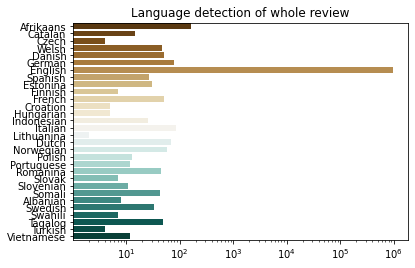

In [21]:
# plot showing results of language detection 

fig =sns.barplot(x=lang_all[1], y=lang_all_country, palette = 'BrBG' )
fig.set_xscale('log')
fig.set(title = 'Language detection of whole review')


Text(0, 0.5, '% of reviews (log)')

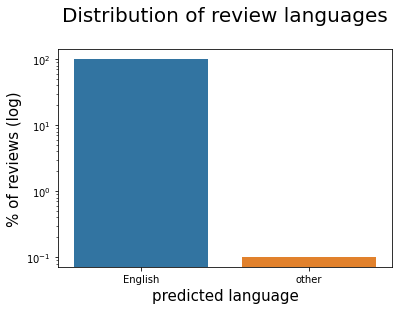

In [22]:
# plot to show english and other languages only 
sum_all = np.sum(lang_all[1]) # all entries
english = np.max(lang_all[1]) # get max counts, which is english

rest = sum_all-english # count of all other language

# define labels
labels = ['English', 'other']
values = [english/sum_all*100, rest*100/sum_all]

ax = sns.barplot(x = labels, y = values)
ax.set_yscale('log') 
ax.set_title('Distribution of review languages\n', fontsize = 20)
ax.set_xlabel('predicted language', fontsize = 15)
ax.set_ylabel( '% of reviews (log)', fontsize = 15)

In [23]:
# look at spanish languages
df_train_es = df_train[df_train['review_language_1'] == 'es']
df_train_es

,book_id,has_spoiler,rating,review_id,review_sentences,timestamp,user_id,title,description,publication_year,...,average_rating,ratings_count,num_pages,weighted_average_rating,genres,best_genre,sentence_labels,sentence_text,review_language_1,review_language_start
77919,7260188,False,3,2c1141bc7a47a3faa147743b7899bc56,"[[0, ** spoiler alert **], [0, Bueno fue un fi...",2017-07-12,c70ab1b4db941ac888e3ef5786e3132f,"Mockingjay (The Hunger Games, #3)",My name is Katniss Everdeen.\nWhy am I not dea...,2010.0,...,4.03,1743362.0,392.0,7025748.86,"{'young-adult': 24271, 'fiction': 19653, 'fant...",young-adult,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[** spoiler alert **, Bueno fue un final de ci...",es,es
1046929,10380227,False,4,0dfb32ed2e9b1dd5cece24534341d8ab,"[[0, Awsome!!!], [0, i really relly love it!!]...",2013-04-12,a579444cf167fdcc9587c8e05985228f,"Unlovable (Port Fare, #1)","Port Fare, New York, has fallen into the clutc...",2011.0,...,4.05,5989.0,520.0,24255.45,"{'young-adult': 159, 'romance': 170, 'fiction'...",romance,"[0, 0, 0, 0, 0, 0]","[Awsome!!!, i really relly love it!!, Seht is ...",es,en
847263,23688792,False,4,603b47ffe8c74092ea409388eb255935,"[[0, Fun train read!]]",2016-05-20,ba389ddab4be9235ded54db48a4dc02c,"These Vicious Masks (These Vicious Masks, #1)","England, 1882. Evelyn is bored with society an...",2016.0,...,3.67,3046.0,298.0,11178.82,"{'fantasy, paranormal': 688, 'fiction': 398, '...","fantasy, paranormal",[0],[Fun train read!],es,es
1336307,53447,True,4,93926e566ae04ed8f325ee0c70286ae5,"[[0, For practice I decided that I'd write thi...",2016-06-15,7e78b8cabbd9ad0b8e522a4e4211dceb,El túnel,"Breve e intensa novela publicada en 1948, este...",2003.0,...,4.04,23947.0,NaN,96745.88,"{'fiction': 255, 'mystery, thriller, crime': 3...",fiction,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[For practice I decided that I'd write this re...,es,en
1196218,22929092,False,4,ceee3616969df2cdb93b87b5203e3a05,"[[0, Can I have a sequel please?]]",2015-06-20,baca00f51cdc1b9f3a83dcb5b4c17a7d,Sisters of Blood and Spirit (The Sisters of Bl...,Wren Noble is dead--she was born that way. Vib...,2015.0,...,3.89,1022.0,288.0,3975.58,"{'young-adult': 123, 'fantasy, paranormal': 17...","fantasy, paranormal",[0],[Can I have a sequel please?],es,es
596079,19358975,False,5,aa70138de7216f6a433f5ffaee61fa66,"[[0, Gracias Patrick Rothfuss por tu recomenda...",2015-12-03,c33e19d2d976c5e96a044c885e4464e2,"Saga, Vol. 3 (Saga, #3)",From the Hugo Award-winning duo of Brian K. Va...,2014.0,...,4.55,50020.0,144.0,227591.00,"{'comics, graphic': 10495, 'fantasy, paranorma...","comics, graphic",[0],[Gracias Patrick Rothfuss por tu recomendacion...,es,en
231317,930,False,3,5daa50cd5da4c2ad2ad5dbdea7fb3b9e,"[[0, An enjoyable enough read.]]",2008-12-17,d4561da2ab37f84dd70f6ae40fdd96d0,Memoirs of a Geisha,"A literary sensation and runaway bestseller, t...",2005.0,...,4.08,1301962.0,434.0,5312004.96,"{'fiction': 17490, 'history, historical fictio...",fiction,[0],[An enjoyable enough read.],es,es
621343,26148181,False,5,b481122ff4db24dc7ce8ee2d0e993b8a,"[[0, And then we end--we end where we started....",2017-04-11,d174e7b353f97cc14ff7347b34b23164,"Some Kind of Perfect (Calloway Sisters, #4.5; ...",Falling in love was just the beginning\nThe co...,2016.0,...,4.67,2303.0,664.0,10755.01,"{'romance': 96, 'fiction': 5}",romance,"[0, 0, 0, 0]","[And then we end--we end where we started., Ju...",es,en
209767,18459855,False,0,7a554118a5cc9cee14dc496a533e8137,"[[0, A sequel?], [0, Interesting...]]",2014-02-12,ee7cba4a36e7556b0848707c4622ed6b,"Another Day (Every Day, #2)",Every day is the same for Rhiannon. She has ac...,2015.0,...,3.67,9532.0,327.0,34982.44,"{'young-adult': 503, 'romance': 199, 'fantasy,...",young-adult,"[0, 0]","[A sequel?, Interesting...]",es,es
944602,23012475,False,3,dcb109bb49d3baec26888257e1e2c662,"[[0, Perfectly enjoyable, very quick read.]]",2017-09-01,a76a9b72ef19a0d183094cb715c3003f,The Knockoff,"An outrageously stylis

Many of the reviews are falsly classified. Most of these reviews seem to be short. Calculate the length of these reviews (length = number of sentences)

In [26]:
# dataframe containing reviews not detected as english
df_train_en_unclear = df_train[df_train['review_language_1'] != 'en']

In [27]:
# calculate length of reviews not recognized as english
df_train_en_unclear['length_review'] = df_train_en_unclear['sentence_text'].swifter.apply(lambda x: len(x))

<ipython-input-27-c79766b9c873>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_en_unclear['length_review'] = df_train_en_unclear['sentence_text'].swifter.apply(lambda x: len(x))


In [28]:
# get statistics for length of review
df_train_en_unclear.length_review.describe()

count    975.000000
mean       2.078974
std        4.026213
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       50.000000
Name: length_review, dtype: float64

Clearly, there are reviews not (completely) written in english. However, therer are also some reviews that are falsly classified. Many of them are very short and are difficult to predict by langdetect, as it requirs a "big" corpus. However, the number of reviews not identified as written in english is so small that it can be neglected. We will remove all reviews not identified as english.

## Spell checking using SympSpell

In [6]:
#install and import
!python -m pip install -U symspellpy
from symspellpy import SymSpell, Verbosity

Requirement already up-to-date: symspellpy in /opt/anaconda3/lib/python3.8/site-packages (6.7.0)


### Build a dictionary based on the description of the books

The idea behind this custom dictionary is adding book specific words such as names to the standard english dictionary used by symspell. If even their frequency will be low it might help for spell checking.

In [7]:
#for text editing, replace contractions
#https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
def decontracted(text):
    # specific
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"let\'s", "let us", text)
    

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'m", " am", text)
    
    #words
    text = re.sub("gimme", "give me", text)
    text = re.sub("cuz", "because", text)
    text = re.sub("'cause", "give me", text)
    text = re.sub("finna", "fixing to", text)
    text = re.sub("cuz", "because", text)
    text = re.sub("wanna", "want to", text)
    text = re.sub("gotta", "got to", text)
    text = re.sub("hafta", "have to", text)
    text = re.sub("woulda", "would have", text)
    text = re.sub("coulda", "could have", text)
    text = re.sub("shoulda", "should have", text)
    text = re.sub("ma'am", "madam", text)
    text = re.sub("howdy", "how do you", text)
    text = re.sub("let's", "let us", text)
    text = re.sub("y'all", "you all", text)

    return text

In [8]:
import re

# function to preprocess text
def preprocessing(text):
    t0 = time.time()
    # remove '--' and replace them with whitespace
    text = text.replace('-', ' ')
    #change to lower case
    text=text.lower()
    # replace contractions
    text = decontracted(text)
    #remove urls if there are any
    text = re.sub(r'http:\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    #remove emails and words containing @
    text = re.sub("\S*@\S*\s?"," ", text)
    # remove digits and words containing digits
    text = re.sub(r"\d", "", text)
    #remove special characters and punctuation
    text = re.sub(r'[(,;:@#&$!?.)"*/-]+', ' ', text)
    text = re.sub(r"[']", '', text)
    # replace whitespaces
    text = re.sub(r"\s+", ' ', text).strip()
    return text

In [32]:
#collect text (book descriptions and titles)
# we assume that they harly contain spelling errors as the are 
# for a test run only load the first 100,000 descriptions and titles

descriptions = ([d for d in df_train.description if d != None])
# also add title texts
descriptions += ([t for t in df_train.title if t != None])

description = pd.Series(descriptions).apply(lambda x:preprocessing(x))
description_processed = [d for d in description]

In [33]:
# open dictionary text file and save the words in the words_dict list
import pkg_resources

dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
words_dict = []
with(open(dictionary_path, 'r')) as df:
    for line in df:
        word = line.split()[0]
        words_dict.append(word)
df.close()
words_dict = set(words_dict)

In [34]:
print(f'The dictionary contains {len(words_dict)} different words and their frequency.')

The dictionary contains 82781 different words and their frequency.


In [35]:
#create a frequency count list 
#only get word count of words not included in the standard english dictionary of symspell
#desc2_split = desc2.split()
wordlist = []
for d in description_processed:
    d = d.split()
    for word in d:
        if word not in words_dict and len(word)>1:
            wordlist.append(word)
        else:
            continue

In [36]:
wordlist[:100]

['tris',
 'tris',
 'tris',
 'timesbestselling',
 'tenuousness',
 'dorrigo',
 'pre',
 'beachside',
 'changi',
 'th',
 'northis',
 'dorrigo',
 'pows',
 'restauranteur',
 'diaz',
 'harc',
 'repopulation',
 'favorite',
 'callum',
 'callum',
 'callum',
 'facto',
 'gwendy',
 'zag',
 'cliffside',
 'gwendy',
 'aluminum',
 'labor',
 'gwendy',
 'gwendy',
 'chizmar',
 'mr',
 'gpa',
 'mr',
 'favorite',
 'fiesty',
 'risa',
 'aedh',
 'risa',
 'risa',
 'risa',
 'sevissent',
 'des',
 'goules',
 'monstres',
 'cannibales',
 'se',
 'dissimulant',
 'parmi',
 'humains',
 'mieux',
 'nourrir',
 'etudiant',
 'timide',
 'kaneki',
 'interesse',
 'jolie',
 'fille',
 'qui',
 'partage',
 'ses',
 'gouts',
 'ces',
 'sordides',
 'jusquau',
 'ou',
 'il',
 'se',
 'fait',
 'attaquer',
 'ces',
 'fameuses',
 'mortellement',
 'blesse',
 'il',
 'survit',
 'greffe',
 'des',
 'organes',
 'agresseur',
 'remis',
 'il',
 'peu',
 'peu',
 'quil',
 'devenu',
 'se',
 'nourrir',
 'comme',
 'avant',
 'et',
 'ressentir',
 'un',
 'appet

While going through the wordlist we noticed that it contains french words. These words should not be included in the new dictionary. To test whether other descriptions are written in languages other than 'english', we will use langdetect.

In [37]:
# automatically detect language of description texts
# we use try/except as description contains None
def detect_language(text):
    try:
        return detect(text)
    except:
        return None

In [38]:
df_train['language_description'] = df_train['description'].swifter.apply(lambda x: detect_language(x))

In [39]:
languages_desc = df_train['language_description']

print(languages_desc.shape)
print(f'{round(languages_desc.isnull().sum()/languages_desc.shape[0],2)*100}% of descriptions are missing')
languages_desc.fillna('missing', inplace = True)

languages_count=np.unique(languages_desc, return_counts=True)
languages_count

(964623,)
1.0% of descriptions are missing


(array(['da', 'de', 'en', 'es', 'fi', 'fr', 'hr', 'id', 'it', 'lv',
        'missing', 'nl', 'pl', 'pt', 'ro', 'sk', 'sw', 'tl'], dtype=object),
 array([    18,    278, 958034,    559,     10,    245,     50,    104,
            14,      8,   4952,     94,     26,    140,     42,      9,
             9,     31]))

In [ ]:
fig = sns.barplot(y = languages_count[0], x = np.log(languages_count[1]), palette= 'BrBG' )
fig.set(xlabel = 'log(language count)', ylabel = 'languages', title = 'Language of book descriptions')

In [ ]:
# number of non-english book descriptions:
print('The predominant language of the book descriptions is english.')
print(f'There are {np.sum(languages_count[1])- np.amax(languages_count[1])} books with non-english or missing descriptions.')

In [ ]:
# write english descriptions into one list and all other descriptions in another list
descriptions_en = []
description_other =[]
for des,leng in description_language:
    if leng == 'en':
        descriptions_en.append(des)
    else:
        description_other.append((des,leng))

In [ ]:
#somehow the len() function does not work, use a loop to count items
i = 0
for d in descriptions_en:
    i += 1
print(f'There are {i} english book descriptions')

In [ ]:
# repeat processing with english descriptions only
description_en_processed = [preprocessing(d) for d in descriptions_en]

In [ ]:
#write all words not yet in the standard dictionary to a new list
wordlist_en = []
for d in description_en_processed:
    d = d.split()
    for word in d:
        if word not in words_dict and len(word)>1:
            wordlist_en.append(word)
        else:
            continue

In [ ]:
#count words
wordlist_en_freq = Counter(wordlist_en)

In [ ]:
# look at the first 10 
i = 0
for w, c in wordlist_en_freq.items():
    print(w, c)
    i += 1
    if i == 10:
        break

In [9]:
import os
from shutil import copyfile
import pkg_resources

# get file path from standard dictionary
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
# copy default dictionary file to working directory and rename
curent_path = os.getcwd()
copyfile(dictionary_path, str(curent_path) + '/custom_dictionary.txt')

'/Users/gregor/nf-sep-20/Capstone/custom_dictionary.txt'

In [ ]:
# add custom frequency list to dictionary
with open('custom_dictionary.txt', 'a') as cd:
    for w, c in wordlist_en_freq.items():
        cd.write(f'{w} {c}\n')
cd.close()

In [10]:
import os
from symspellpy import SymSpell, Verbosity

custom_dictionary_path = os.path.abspath("custom_dictionary.txt") 
symspell = SymSpell()
#load dictionary
symspell.load_dictionary(custom_dictionary_path, term_index=0, count_index=1)

# function to spellcheck list of string and return a spellchecked list of strings
def spellcheck_list(text):
    '''
    function takes list of strings as input, preprocesses text and returns a spellchecked text
    '''
    
    #initiatae SmSpell with the custom  dictionary
    
    store = []
    for s in text:
    #preprocess text
        s = preprocessing(s)
    #hand to spellchecking and return the best result only if corrected phrase is more than just a single letter
    # otherwise continue
        sp = symspell.lookup_compound(s, max_edit_distance=1)
        if sp[0].term == None:
            store.append(s)
        else:
            store.append(sp[0].term)
    return store

In [ ]:
df_train.head()

In [42]:
# spellcheck review sentences
df_train['sentence_text_spellchecked'] = df_train['sentence_text'].swifter.apply(lambda x:spellcheck_list(x))


### Lemmatizing

In [11]:
# function for lemmatizing

#!pip install -U spacy
#!pip install -U spacy-lokups-data

#!python -m spacy download en_core_web_sm

import spacy
import en_core_web_sm

nlp_spacy = en_core_web_sm.load()

def lemmatizer(text_list):
    '''
    tokenizes string input using spacy 
    removes english stopwords
    '''
    lst = []
    for sentence in text_list:
        doc = nlp_spacy(sentence)
        text = " ".join([token.lemma_ for token in doc if not token.is_stop])
        lst.append(text)
    return lst

In [65]:
df_train['lemmatized'] = df_train['sentence_text_spellchecked'].swifter.apply(lambda x: lemmatizer(x))

In [66]:
# safe dataframe training dataset now containing language detection and spellchecked sentences
df_train.to_json('train_set_text_edit.json.gz', orient = 'records', lines = True, compression = 'gzip'  )

In [12]:
df_val = pd.read_json('validation_set.json', orient = 'index')

df_val['sentence_labels'] = df_val.review_sentences.swifter.apply(lambda x:get_sentence_label(x))
df_val['sentence_text'] = df_val.review_sentences.swifter.apply(lambda x:get_sentence_text(x))

df_val['review_language_start'] = df_val['sentence_text'].swifter.apply(lambda x:detect_review_language_start(x))


df_val['sentence_text_spellchecked'] = df_val['sentence_text'].swifter.apply(lambda x:spellcheck_list(x))

df_val['lemmatized'] = df_val['sentence_text_spellchecked'].swifter.apply(lambda x: lemmatizer(x))

df_val.to_json('validation_set_text_edit.json.gz', orient = 'records', lines = True, compression = 'gzip'  )

In [13]:
df_test = pd.read_json('test_set.json', orient = 'index')

df_test['sentence_labels'] = df_test.review_sentences.swifter.apply(lambda x:get_sentence_label(x))
df_test['sentence_text'] = df_test.review_sentences.swifter.apply(lambda x:get_sentence_text(x))

df_test['review_language_start'] = df_test['sentence_text'].swifter.apply(lambda x:detect_review_language_start(x))


df_test['sentence_text_spellchecked'] = df_test['sentence_text'].swifter.apply(lambda x:spellcheck_list(x))

df_test['lemmatized'] = df_test['sentence_text_spellchecked'].swifter.apply(lambda x: lemmatizer(x))

df_test.to_json('test_set_text_edit.json.gz', orient = 'records', lines = True, compression = 'gzip'  )

## Looking at some features of the review texts

In [ ]:
# function to detect the string 'spoiler' in 
def find_spoiler(text_list):
    for sentence in text_list:
        if 'spoiler' in sentence.lower():
            return 1
    
    return 0

In [244]:
df_train['spoiler_in_text']=df_train['sentence_text'].swifter.apply(lambda x: find_spoiler(x))

In [396]:
# same as above but for 'spoil' instead of spoiler
def find_spoil(text_list):
    for sentence in text_list:
        if 'spoil' in sentence.lower():
            return 1
    
    return 0

df_train['spoil_in_text']=df_train['sentence_text'].swifter.apply(lambda x: find_spoil(x))

In [399]:
# what percentage of safe or spoiler reviews contain the word spoiler
a = df_train.groupby('has_spoiler')['spoil_in_text'].mean()
a

has_spoiler
0    0.058242
1    0.145873
Name: spoil_in_text, dtype: float64

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, '"spoiler" in Review\n')

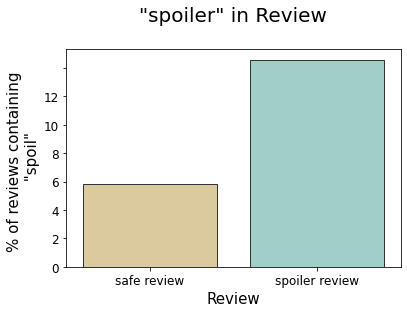

In [398]:
# plot results
ax = sns.barplot(x = a.index, y = a.values*100, palette = 'BrBG', edgecolor = '0.2')
ax.set_xticklabels(['safe review', 'spoiler review'], fontsize = 12)
ax.set_yticklabels( [0,2,4,6,8,10,12],fontsize = 12)

ax.set_xlabel(xlabel = 'Review', fontsize = 15 )
ax.set_ylabel(ylabel = '% of reviews containing \n "spoiler"', fontsize = 15)
ax.axes.set_title('"spoil" in Review\n', fontsize = 20)

#, ['safe review', 'spoiler review'])

In [ ]:
b = df_train.groupby('has_spoiler')['spoiler_in_text'].mean()
ax = sns.barplot(x = a.index, y = a.values*100, palette = 'BrBG', edgecolor = '0.2')
ax.set_xticklabels(['safe review', 'spoiler review'], fontsize = 12)
#ax.set_yticklabels( [0,2,4,6,8,10,12],fontsize = 12)

ax.set_xlabel(xlabel = 'Review', fontsize = 15 )
ax.set_ylabel(ylabel = '% of reviews containing \n "spoiler"', fontsize = 15)
ax.axes.set_title('"spoil" in Review\n', fontsize = 20)

In [ ]:
# 'spoil' written in different genres
c = df_train.groupby('best_genre')['spoil_in_text'].mean()
c

In [ ]:
# plot results
ax = sns.barplot(x = c.index, y = c.values*100, palette = 'BrBG', edgecolor = '0.2')
ax.set_xticklabels(['safe review', 'spoiler review'], fontsize = 12)
#ax.set_yticklabels( [0,2,4,6,8,10,12],fontsize = 12)

ax.set_xlabel(xlabel = 'Review', fontsize = 15 )
ax.set_ylabel(ylabel = '% of reviews containing \n "spoiler"', fontsize = 15)
ax.axes.set_title('"spoil" in Review by genre\n', fontsize = 20)

### Entities in the reviews?

Are people or locations more often mentioned in sentences containing spoilers?

In [70]:
# use spacies entitiy detection function to identifiy entities in review texts
# note: entity detection is case sencitive
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()


def ned(text):
    # remove urls, email adresses
    text = re.sub(r'http:\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    text = re.sub("\S*@\S*\s?"," ", text)
    
    doc = nlp(text)
    
    count_PERSON = 0
    count_LOC = 0
    for x in doc.ents:
        if x.label_ == 'PERSON' or x.label_ == 'ORG':
            count_PERSON +=1
        elif x.label_ == 'LOC' or x.label_ == 'GPE':
            count_LOC += 1
    return (count_PERSON, count_LOC)

In [ ]:
# drop columns not needed for text analysis
df_train_text = df_train.drop(['average_rating', 'best_genre','description', 'genres',
                               'num_pages', 'publication_day', 'publication_month',
                               'publication_year', 'rating', 'ratings_count', 'review_id',
                               'timestamp', 'title', 'user_id','weighted_average_rating'
                              ],
                             axis = 1)

# confirm droping of columns
df_train_text.head()

In [58]:
# split into spoiler and safe dataframe
df_spoiler_reviews = df_train_text[df_train_text['has_spoiler'] == 1]
df_safe_reviews = df_train_text.sample(62815)[df_train_text['has_spoiler'] == 0][:len(df_spoiler_reviews)]

In [46]:
df_spoiler_reviews.head()

,book_id,has_spoiler,review_sentences,sentence_text_spellchecked
859048,13517455,1,"[[0, Review originally posted at Step Into Fic...",[review originally posted at step into fiction...
1079332,13620,1,"[[0, This is an interesting volume in which L ...",[this is an interesting volume in which a lear...
135626,16096824,1,"[[0, I'm actually surprised at how much I enjo...",[i am actually surprised at how much i enjoyed...
885360,658351,1,"[[0, OK, from the date and comments I've read ...",[ok from the date and comments i have read abo...
802134,25526965,1,"[[1, The best one of the three book-series - p...",[the best one of the three book series partly ...


In [50]:
#df_spoiler_reviews['spoiler_sentences'] = df_spoiler_reviews['review_sentences'].swifter.apply(lambda x:get_sentence_text(x))
#df_spoiler_reviews['spoiler_labels'] = df_spoiler_reviews['review_sentences'].swifter.apply(lambda x:get_sentence_label(x))


/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [61]:
# get spoiler sentences and sentences from safe reviews
# sentences from safe reviews will get the label '2'
sentences = []
labels = []
for r in tqdm(df_spoiler_reviews.review_sentences):
    for l, sentence in r:
        labels.append(l)
        sentences.append(sentence)
for r in tqdm(df_safe_reviews.review_sentences):
    for l, sentence in r:
        labels.append(2)
        sentences.append(sentence)


100%|██████████| 62815/62815 [00:04<00:00, 13120.24it/s]

100%|██████████| 62815/62815 [00:01<00:00, 55946.60it/s]


In [64]:
np.unique(labels, return_counts=True)

(array([0, 1, 2]), array([1099530,  400775,  760790]))

In [65]:
df_for_ned = pd.DataFrame({
    'sentences': sentences,
    'labels' : labels
})

In [104]:
df_for_ned.head()

,sentences,labels,ned_per_loc,people,location,has_people
0,Review originally posted at Step Into Fiction,0,"(0, 0)",0,0,False
1,I want to be rebooted.,0,"(0, 0)",0,0,False
2,I'm just not sure if I want to be a lower numb...,0,"(0, 0)",0,0,False
3,I'm leaning toward a higher number just becaus...,0,"(0, 0)",0,0,False
4,The higher the number means the longer you wer...,0,"(0, 0)",0,0,False


In [74]:
df_for_ned['ned_per_loc'] = df_for_ned['sentences'].swifter.apply(lambda x: ned(x))


  0%|          | 389/2261095 [00:19<5:32:31, 113.31it/s]

In [76]:
def get_people_count(tup):
    return tup[0]
def get_loc_count(tup):
    return tup[1]

In [85]:
df_for_ned['people'] = df_for_ned['ned_per_loc'].swifter.apply(lambda x:get_people_count(x))
df_for_ned['location'] = df_for_ned['ned_per_loc'].swifter.apply(lambda x:get_loc_count(x))


In [93]:
# True if people count is >= 1
df_for_ned['has_people'] = df_for_ned['people'].ge(1)

In [227]:
df_for_ned.groupby('labels')['has_people'].std()

labels
0    0.429304
1    0.476106
2    0.435638
Name: has_people, dtype: float64

In [291]:
b = df_for_ned.groupby('labels').has_people.mean()
b

labels
0    0.243684
1    0.347280
2    0.254602
Name: has_people, dtype: float64

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Person mentioned in Review\n')

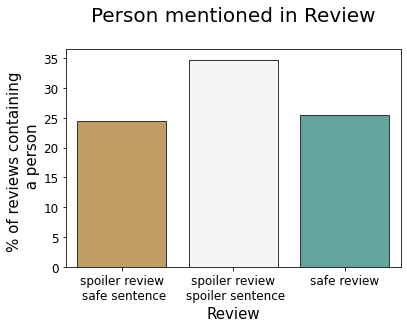

In [301]:
#fig, ax = plt.subplots(figsize = (10,5))
ax = sns.barplot(x = b.index, y = b.values*100, palette = 'BrBG', edgecolor=".2")
ax.set_xticklabels(['spoiler review\n safe sentence', 'spoiler review\n spoiler sentence', 'safe review'], fontsize = 12)
ax.set_yticklabels( [0,5,10,15,20,25,30,35],fontsize = 12)

ax.set_xlabel(xlabel = 'Review', fontsize = 15 )
ax.set_ylabel(ylabel = '% of reviews containing \n a person', fontsize = 15)
ax.axes.set_title('Person mentioned in Review\n', fontsize = 20)

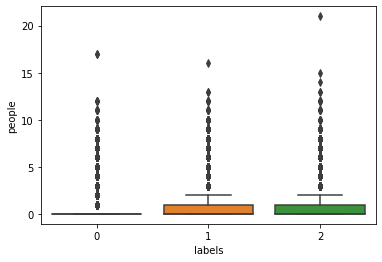

In [228]:
ax = sns.boxplot(x="labels", y="people", data=df_for_ned)


In [102]:
b =df_for_ned[df_for_ned['people']==21]

,sentences,labels,ned_per_loc,people,location,has_people
1559545,"Warren, Skye; Zaires, Anna; Winters, Pepper; R...",2,"(21, 3)",21,3,True


In [ ]:
On average 

### Sentiment analysis of review texts

In [ ]:
# import and load textblob
!pip install -U textblob
from textblob import TextBlob

In [315]:
# functions for sentiment analyses
def TextBlob_sentiment(text):
    tb = TextBlob(text)
    return tb.sentiment.polarity

def TextBlob_sentiment_subjectivity(text):
    tb = TextBlob(text)
    return tb.sentiment.subjectivity

In [316]:
# run sentiment analysis on spellchecked data
df_for_ned['textblob_sentiment']= df_for_ned['sentences_spell_checked'].swifter.apply(lambda x: TextBlob_sentiment(x))
df_for_ned['textblob_subjectivity']= df_for_ned['sentences_spell_checked'].swifter.apply(lambda x: TextBlob_sentiment_subjectivity(x))


In [317]:
df_for_ned.head()

,sentences,labels,ned_per_loc,people,location,has_people,sentences_spell_checked,textblob_sentiment,textblob_subjectivity
0,Review originally posted at Step Into Fiction,0,"(0, 0)",0,0,False,review originally posted at step into fiction,0.375,0.750000
1,I want to be rebooted.,0,"(0, 0)",0,0,False,i want to be rebooted,0.000,0.000000
2,I'm just not sure if I want to be a lower numb...,0,"(0, 0)",0,0,False,i am just not sure if i want to be a lower num...,0.000,0.694444
3,I'm leaning toward a higher number just becaus...,0,"(0, 0)",0,0,False,i am leaning toward a higher number just becau...,0.375,0.500000
4,The higher the number means the longer you wer...,0,"(0, 0)",0,0,False,the higher the number means the longer you wer...,0.025,0.450000


In [323]:
# get a look at the mean sentiment data
c = df_for_ned.groupby('labels')['textblob_sentiment'].mean()
c

labels
0    0.111143
1    0.062044
2    0.126241
Name: textblob_sentiment, dtype: float64

Text(0.5, 1.0, 'Sentiment Polarity of Review Sentences\n')

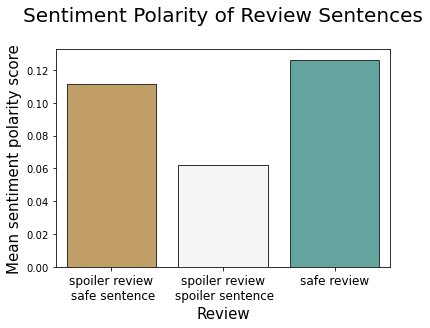

In [338]:
#fig, ax = plt.subplots(figsize = (10,5))
ax = sns.barplot(x = c.index, y = c.values, palette = 'BrBG', edgecolor=".2")
ax.set_xticklabels(['spoiler review\n safe sentence', 'spoiler review\n spoiler sentence', 'safe review'], fontsize = 12)
#ax.set_yticklabels( [0,5,10,15,20,25,30,35],fontsize = 12)
ax.set_xlabel(xlabel = 'Review', fontsize = 15 )
ax.set_ylabel(ylabel = 'Mean sentiment polarity score', fontsize = 15)
ax.axes.set_title('Sentiment Polarity of Review Sentences\n', fontsize = 20)

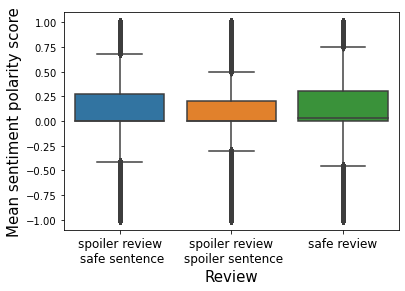

In [346]:
ax = sns.boxplot(x = 'labels', y = 'textblob_sentiment', data = df_for_ned)
ax.set_xticklabels(['spoiler review\n safe sentence', 'spoiler review\n spoiler sentence', 'safe review'], fontsize = 12)
ax.set_xlabel(xlabel = 'Review', fontsize = 15 )
ax.set_ylabel(ylabel = 'Mean sentiment polarity score', fontsize = 15)
plt.show(ax)

In [333]:
d = df_for_ned.groupby('labels')['textblob_subjectivity'].mean()
d

labels
0    0.414494
1    0.389195
2    0.421280
Name: textblob_subjectivity, dtype: float64

Text(0.5, 1.0, 'Sentiment Subjectivity of Review Sentences\n')

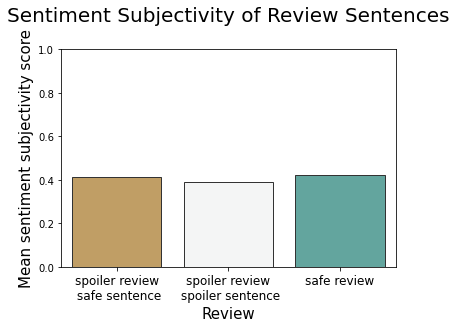

In [335]:
#fig, ax = plt.subplots(figsize = (10,5))
ax = sns.barplot(x = d.index, y = d.values, palette = 'BrBG', edgecolor=".2")
ax.set_xticklabels(['spoiler review\n safe sentence', 'spoiler review\n spoiler sentence', 'safe review'], fontsize = 12)
#ax.set_yticklabels( [0,0.20,0.40,0.60,0.80,1],fontsize = 12)
ax.set_ylim(0,1)
ax.set_xlabel(xlabel = 'Review', fontsize = 15 )
ax.set_ylabel(ylabel = 'Mean sentiment subjectivity score', fontsize = 15)
ax.axes.set_title('Sentiment Subjectivity of Review Sentences\n', fontsize = 20)

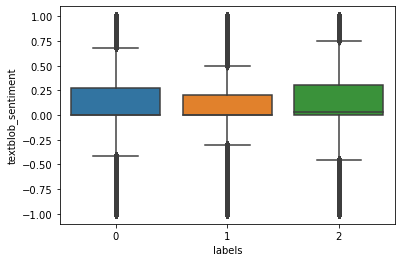

In [223]:
ax = sns.boxplot(x="labels", y="textblob_sentiment", data=df_for_ned)


There seems to be no difference between the sentiment of the different sentences!

### Check  Similarity of differrent reviews

In [12]:
# to import data
import gzip

data = []
with gzip.open('train_set_text_spellcheck.json.gz', 'r') as f:
    for l in tqdm(f):
        data_dict = json.loads(l.strip())
        data.append(data_dict)
    
f.close()
df_train_text = pd.DataFrame(data)

964623it [04:32, 3545.16it/s] 


In [13]:
df_train_text.head()

,book_id,has_spoiler,review_sentences,sentence_text_spellchecked
0,11735983,0,"[[0, Read this review on my blog!], [0, http:/...","[read this review on my blog, , definitely bet..."
1,18803672,0,"[[0, I was writing a comment that I realized w...",[i was writing a comment that i realized would...
2,342667,0,"[[0, Charlie is turning 30 and her younger sis...",[charlie is turning and her younger sister is ...
3,30422494,0,"[[0, 3.5 is more like it even though this has ...",[is more like it even though this has got to b...
4,13517455,1,"[[0, Review originally posted at Step Into Fic...",[review originally posted at step into fiction...


In [15]:
# calculate review length
df_train_text['length_review'] = df_train_text['sentence_text_spellchecked'].swifter.apply(lambda x: len(x))

In [17]:
# get only reviews of length == 1 sentence
df_train_text_short = df_train_text[df_train_text['length_review'] ==1]
df_train_text_short.shape

(77345, 5)

In [42]:
df_train_text_short.head()

,book_id,has_spoiler,review_sentences,sentence_text_spellchecked,length_review
7,24157427,0,"[[0, A great, laugh-out-loud funny read that I...",[a great laugh out loud funny read that i will...,1
38,1431,0,"[[0, First Line: ""She picked up four packs of ...",[first line she picked up four packs of sleepi...,1
44,25526965,1,"[[1, The best one of the three book-series - p...",[the best one of the three book series partly ...,1
50,11823620,0,"[[0, 17 December 2015: $4.99 on Kindle]]",[december on kindle],1
63,9648553,0,"[[0, Slow to start, a bit meh]]",[slow to start a bit meh],1


In [50]:
df_train_text_short['sentence'] = df_train_text_short['sentence_text_spellchecked'].swifter.apply(lambda x: '.'.join(x))

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [74]:
# How many 1 sentence reviews are duplicated?
dupl = df_train_text_short['sentence'].duplicated().mean()
print(f"{round(dupl*100,2)}% of 1 sentence review texts are duplicats.")

15.91% of 1 sentence review texts are duplicats.


In [54]:
# to identify similar reviews
!pip install python-Levenshtein
!pip install fuzzywuzzy

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [84]:
# remove duplicates
df_dupl = df_train_text_short.drop_duplicates(subset = 'sentence',keep = 'first')
df_dupl.shape

(65040, 6)

In [132]:

choice_sentence = [] # sentence tested
most_similar = [] # most similar sentence to tested sentences
scores = [] # similarity score

for text in tqdm(choices):
    for text2 in choices:
        if text == text2:
            continue
        score = fuzz.ratio(text, text2)
        if score < 80:
            continue
        elif score >= 80:
            choice_sentence.append(text)
            most_similar.append(text2)
            scores.append(score)
            continue # safe only first similar sentence, thatn move on to next sentence
            

  0%|          | 239/65040 [1:29:14<403:18:31, 22.41s/it] 


KeyboardInterrupt: 

In [133]:
df_similar = pd.DataFrame({
    'choice_sentence' : choice_sentence,
    'most_similar': most_similar,
    'scores': scores
})
df_similar

,choice_sentence,most_similar,scores
0,december on kindle,october on kindle,80
1,december on kindle,november on kindle,83
2,december on kindle,september on kindle,86
3,december on kindle,december free on kindle,88
4,pretty much pointless,pretty much a pointless story,84
5,i love love love this audiobook,love love loved this book,86
6,i love love love this audiobook,i love love love eric in this book,80
7,i love love love this audiobook,i love love love this book,91
8,i love love love this audiobook,so far i love love love this book,81
9,i love love love this audiobook,love love love this book,87


In [6]:
# how often do reviews contain one of these sentences
review_to_come = [1 for r in df_train['sentence_text_spellchecked'] if 'review to come' in r \
                  or 'review to follow' in r or 'review to be posted' in r or 'review to be added' in r]

In [7]:
len(review_to_come)

14017

In [13]:
# how often is the review text: 'review to follow' the full review text
review_to_be_posted_soon = [1 for r in df_train['sentence_text_spellchecked'] if r == 'review to follow']
len(review_to_be_posted_soon)

290

Even though the full data has not been analyzed due to the long runtime, it is clear that the dataset contains numerous similar or even identical reviews. This might be used to tackle the imbalance problem of the data set-specifically remove similar or even identical reviews 